In [3]:
import pickle
import pandas as pd
import matplotlib.pyplot as plt

In [17]:
# reading the pkl file of the stubs
with open('../tracker_stubs/ball_detections.pkl', 'rb') as f:
    ball_positions = pickle.load(f)

In [18]:
def interpolate_ball_positions(ball_detections):
        ball_positions = [x.get(1,[]) for x in ball_detections]
        df_ball_positions = pd.DataFrame(ball_positions, columns = ['x1', 'y1', 'x2', 'y2'])

        # interpolating missing ball positions for empty bounding boxes in frames
        df_ball_positions = df_ball_positions.interpolate()
        df_ball_positions = df_ball_positions.bfill() # fills missing values with the next valid observation

        # ball_positions = [{1:x} for x in df_ball_positions.to_numpy().tolist()] # 1 is the ball track id

        return df_ball_positions

In [45]:
df_ball_positions = interpolate_ball_positions(ball_positions)
df_ball_positions['mid_y'] = (df_ball_positions['y1'] + df_ball_positions['y2']) / 2
df_ball_positions['mid_y_rolling_mean'] = df_ball_positions['mid_y'].rolling(window = 5, min_periods = 1, center = False).mean()

In [46]:
df_ball_positions.head()

,x1,y1,x2,y2,mid_y,mid_y_rolling_mean
0,901.401184,569.888306,928.840454,598.203247,584.045776,584.045776
1,890.476685,612.083557,915.819763,638.194763,625.139160,604.592468
2,873.598206,635.423401,898.812195,660.007141,647.715271,618.966736
3,858.048157,644.976929,881.599915,669.531738,657.254333,628.538635
4,845.327901,659.265503,867.234884,682.119893,670.692698,636.969448


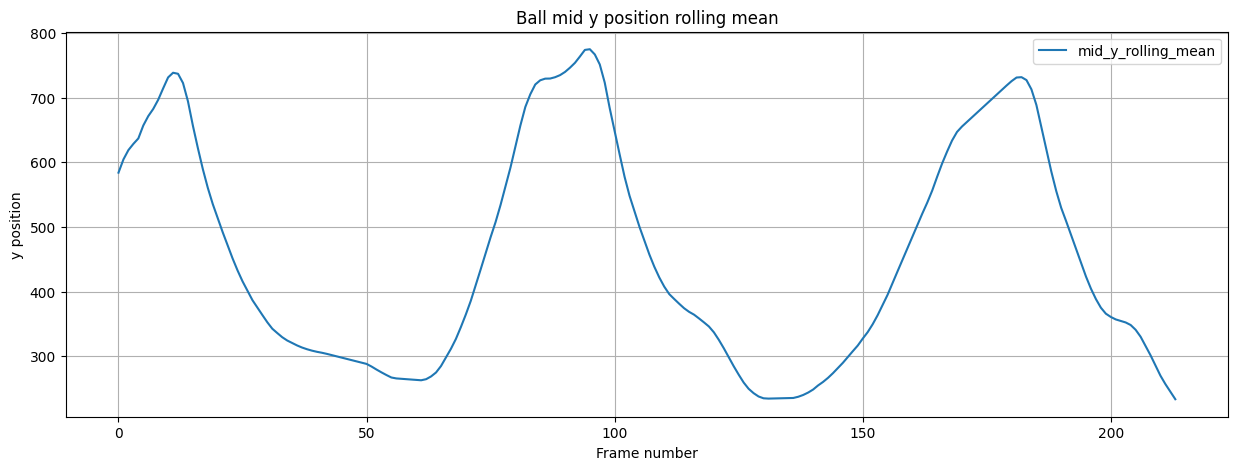

In [47]:
# plot mid_y_rolling_mean
plt.figure(figsize=(15, 5))
plt.plot(df_ball_positions['mid_y_rolling_mean'], label='mid_y_rolling_mean')
plt.title('Ball mid y position rolling mean')
plt.xlabel('Frame number')
plt.ylabel('y position')
plt.legend()
plt.grid()
plt.show()

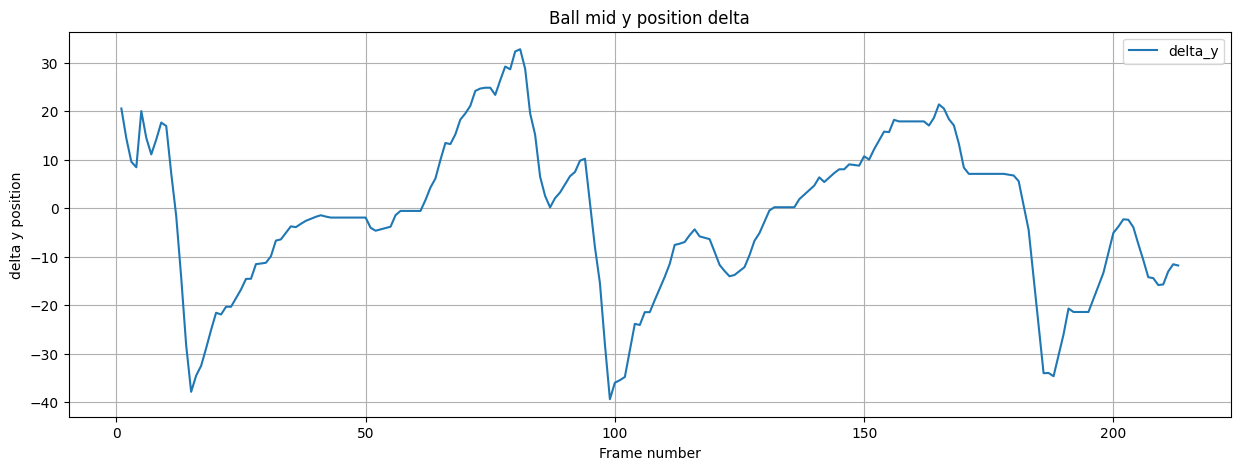

In [48]:
df_ball_positions['delta_y'] = df_ball_positions['mid_y_rolling_mean'].diff() # difference of 2 consecutive frames/rows
plt.figure(figsize=(15, 5))
plt.plot(df_ball_positions['delta_y'], label='delta_y')
plt.title('Ball mid y position delta')
plt.xlabel('Frame number')
plt.ylabel('delta y position')
plt.legend()
plt.grid()
plt.show()

In [49]:
df_ball_positions['ball_hit'] = 0

In [57]:
minimum_change_frames_for_hit = 25 # minimum number of frames the ball changes position for after an impulse
for i in range(1, len(df_ball_positions) - int(minimum_change_frames_for_hit*1.2)):
    negative_position_change = df_ball_positions['delta_y'].iloc[i] > 0 and df_ball_positions['delta_y'].iloc[i + 1] < 0
    positive_position_change = df_ball_positions['delta_y'].iloc[i] < 0 and df_ball_positions['delta_y'].iloc[i + 1] > 0

    if negative_position_change or positive_position_change:
        change_count = 0
        for change_frame in range(i+1, i + int(minimum_change_frames_for_hit*1.2) + 1):
            negative_position_change_following_frame = df_ball_positions['delta_y'].iloc[i] > 0 and df_ball_positions['delta_y'].iloc[change_frame] < 0
            positive_position_change_following_frame = df_ball_positions['delta_y'].iloc[i] < 0 and df_ball_positions['delta_y'].iloc[change_frame] > 0

            if negative_position_change and negative_position_change_following_frame:
                change_count += 1
            elif positive_position_change and positive_position_change_following_frame:
                change_count += 1


        if change_count >  minimum_change_frames_for_hit -1:
            df_ball_positions.loc[i, 'ball_hit'] = 1

In [58]:
df_ball_positions[df_ball_positions['ball_hit'] == 1]

,x1,y1,x2,y2,mid_y,mid_y_rolling_mean,delta_y,ball_hit
11,776.060303,721.428772,797.633423,745.693359,733.561066,738.518335,7.198328,1
61,897.084229,252.170242,916.841309,271.709412,261.939827,263.075439,-0.567806,1
95,622.855743,748.430817,642.374695,767.326477,757.878647,774.892746,1.069919,1
131,713.343363,226.051756,732.145345,244.206063,235.128910,234.743608,-0.478680,1
182,1287.262329,712.275421,1307.111450,731.134521,721.704971,731.673795,0.541202,1


In [59]:
frame_nums_with_ball_hits = df_ball_positions[df_ball_positions['ball_hit'] == 1].index.tolist()